## Introduction

### Goal

This notebook demonstrates a methodology for classifying images based on facial expressions into distinct emotion categories. The primary focus is on Facial Emotion Recognition (FER), a challenging yet fascinating area of machine learning.

### Dataset Overview

For this task, I have utilized the CK+ (Cohn-Kanade Plus) dataset. It's crucial to note that CK+ is a relatively small dataset comprising 981 images. Despite its limited size, CK+ is widely recognized for its high-quality, labeled facial expression images, making it a suitable choice for deep learning experiments in emotion classification.

### Model Architecture and Implementation

The core of this project is the implementation of a 2D Convolutional Neural Network (CNN2D). CNNs are particularly effective for image classification tasks due to their ability to extract features from spatial data. The architecture of the CNN2D model used in this project is designed to efficiently process and classify facial expression images.

### Results

The model achieved a remarkable validation accuracy of 96.46%. This high level of accuracy indicates the model's effectiveness in recognizing and classifying emotions from facial expressions.
Importing Necessary Libraries


## Setting up Directory

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!kaggle datasets download -d dilkushsingh/facial-emotion-dataset

Dataset URL: https://www.kaggle.com/datasets/dilkushsingh/facial-emotion-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 60.0M/60.7M [00:04<00:00, 17.9MB/s]
100% 60.7M/60.7M [00:05<00:00, 12.7MB/s]


In [3]:
!unzip /content/facial-emotion-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train_dir/sad/img_161024360.jpg  
  inflating: /content/train_dir/sad/img_161024361.jpg  
  inflating: /content/train_dir/sad/img_161024362.jpg  
  inflating: /content/train_dir/sad/img_161024363.jpg  
  inflating: /content/train_dir/sad/img_161024364.jpg  
  inflating: /content/train_dir/sad/img_161024365.jpg  
  inflating: /content/train_dir/sad/img_161024366.jpg  
  inflating: /content/train_dir/sad/img_161024367.jpg  
  inflating: /content/train_dir/sad/img_161024368.jpg  
  inflating: /content/train_dir/sad/img_161024369.jpg  
  inflating: /content/train_dir/sad/img_161024370.jpg  
  inflating: /content/train_dir/sad/img_161024371.jpg  
  inflating: /content/train_dir/sad/img_161024372.jpg  
  inflating: /content/train_dir/sad/img_161024373.jpg  
  inflating: /content/train_dir/sad/img_161024374.jpg  
  inflating: /content/train_dir/sad/img_161024375.jpg  
  inflating: /content/train_dir/sad/img_161024376.jpg

## Installing Packages

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import imghdr
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import load_model  # For loading a saved Keras model
from keras.regularizers import l2  # For applying L2 regularization to prevent overfitting
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

import warnings  # For handling warnings
import sys  # For interacting with the Python interpreter
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore simple warnings if not already done
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings

## Setting up Directory to saving each model

In [ ]:
# Defining project name
project_name = 'Facial_Emotion_Recognizer'

# Listing models
model_names = [
    'Custom_CNN_From_Scratch',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (MyDrive space)
base_dir = '/content/drive/MyDrive/FER'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/drive/MyDrive/FER/Facial_Emotion_Recognizer


## Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train_dir'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

## Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train_dir'
test_dir = '/content/test_dir'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       neutral  angry   sad  surprise  happy  disgust  fear
train     5036   3880  4959      3169   6395     2324  3654
      neutral  angry   sad  surprise  happy  disgust  fear
test     1259    971  1240       793   1599      567   911


<Axes: >

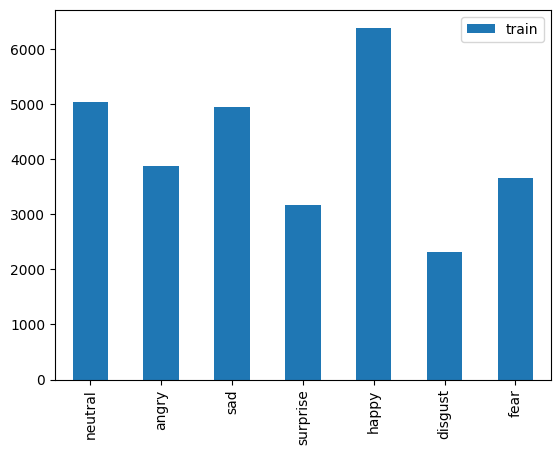

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

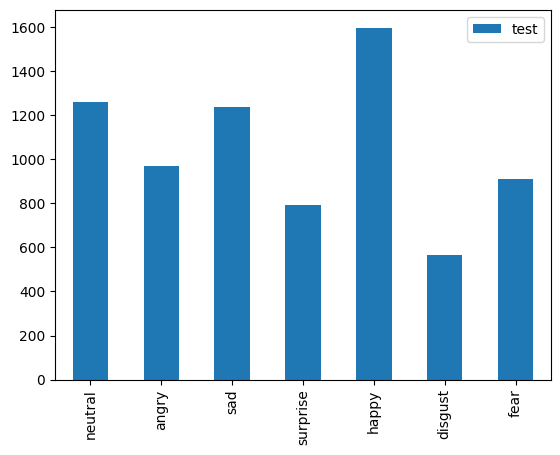

In [ ]:
test_count.transpose().plot(kind='bar')

## Plotting one image from each emotion

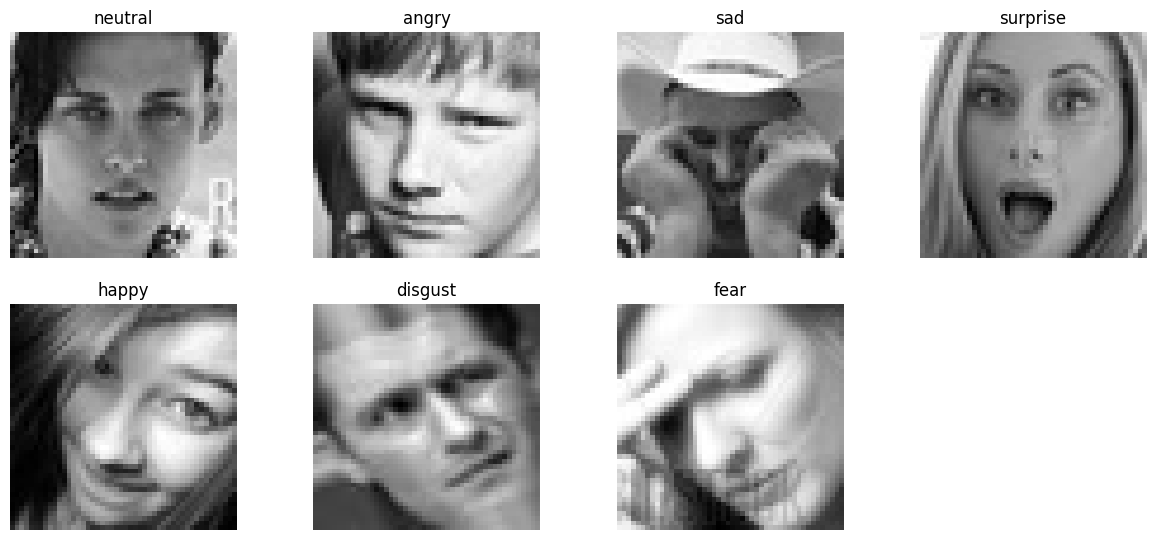

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## Checking Image shape and channel

In [ ]:
import cv2

# Load the image
img = cv2.imread('/content/train_dir/angry/img_16101.jpg', cv2.IMREAD_GRAYSCALE)

print("Shape:", img.shape)

Shape: (48, 48)


# Model 1: Custom CNN from Scratch

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train_dir'
test_data_dir = '/content/test_dir'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 23537 images belonging to 7 classes.
Found 5880 images belonging to 7 classes.
Found 7340 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(filters=512, kernel_size=(5,5), input_shape=(img_width, img_height, 1), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Conv2D(filters=256, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_2'))
model.add(BatchNormalization(name='batchnorm_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_3'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_4'))
model.add(BatchNormalization(name='batchnorm_4'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_5'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_6'))
model.add(BatchNormalization(name='batchnorm_6'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

# Flattening and adding dense layers
model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='elu', kernel_initializer='he_normal', name='dense_1'))
model.add(BatchNormalization(name='batchnorm_7'))
model.add(Dropout(0.25, name='dropout_4'))

# Output layer
model.add(Dense(7, activation='softmax', name='out_layer'))

# Model Compilation
model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 512)       13312     
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 512)       2048      
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 256)       3277056   
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 256)       1024      
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 256)       0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 256)       0

### Plotting the Model

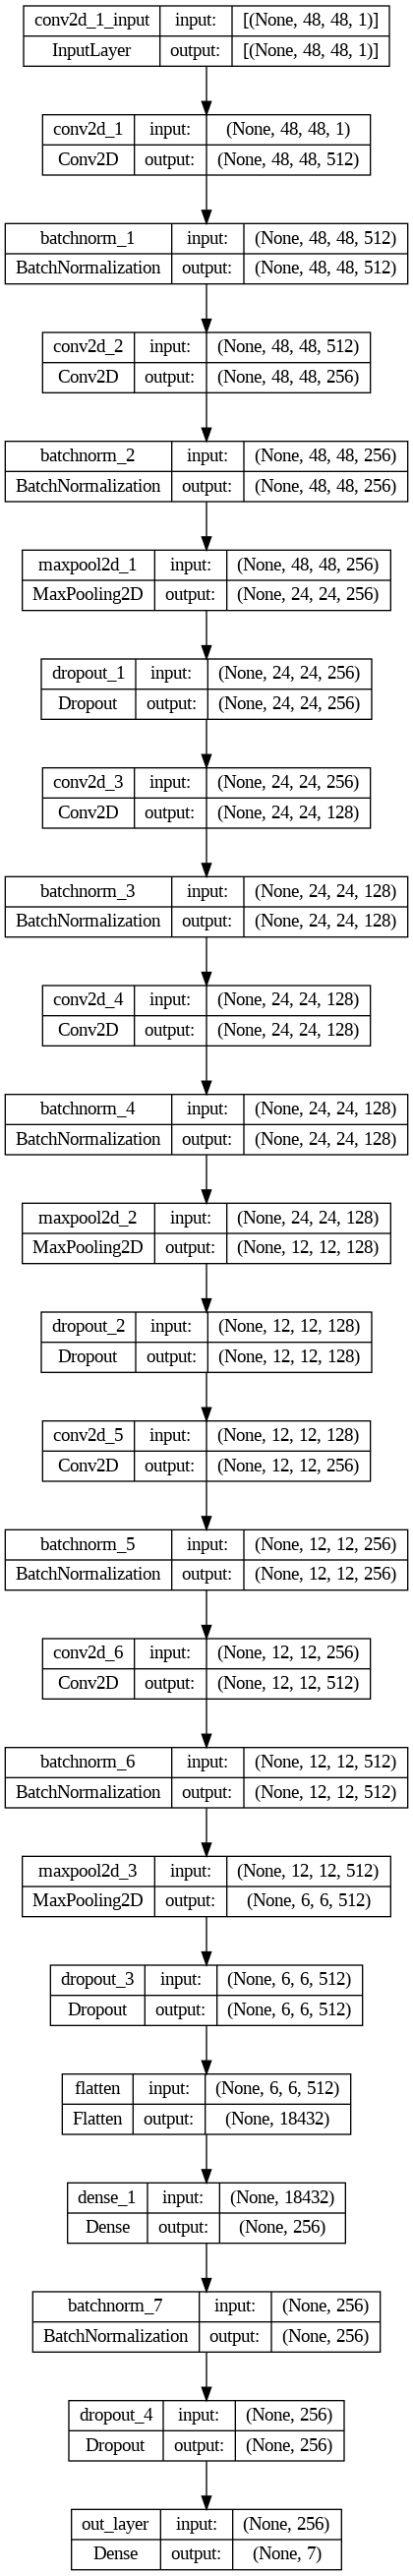

In [ ]:
plot_model(model, to_file = '/content/drive/MyDrive/FER/Facial_Emotion_Recognizer/Custom_CNN_From_Scratch/Architecture.png', show_shapes=True, show_layer_names=True)

## Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/FER/Facial_Emotion_Recognizer/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

## Model Training

In [ ]:
train_generator.samples

23537

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1

test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks
)

Epoch 1/50
368/368 [==============================] - ETA: 0s - loss: 1.7456 - accuracy: 0.3549
Epoch 1: val_loss improved from inf to 1.70565, saving model to /content/drive/MyDrive/FER/Facial_Emotion_Recognizer/Custom_CNN_From_Scratch/Custom_CNN_model.keras
368/368 [==============================] - 193s 441ms/step - loss: 1.7456 - accuracy: 0.3549 - val_loss: 1.7056 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 2/50
368/368 [==============================] - ETA: 0s - loss: 1.3550 - accuracy: 0.4911
Epoch 2: val_loss improved from 1.70565 to 1.60577, saving model to /content/drive/MyDrive/FER/Facial_Emotion_Recognizer/Custom_CNN_From_Scratch/Custom_CNN_model.keras
368/368 [==============================] - 149s 406ms/step - loss: 1.3550 - accuracy: 0.4911 - val_loss: 1.6058 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 3/50
368/368 [==============================] - ETA: 0s - loss: 1.1364 - accuracy: 0.5725
Epoch 3: val_loss improved from 1.60577 to 1.50126, saving model to /content/drive/M

## Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

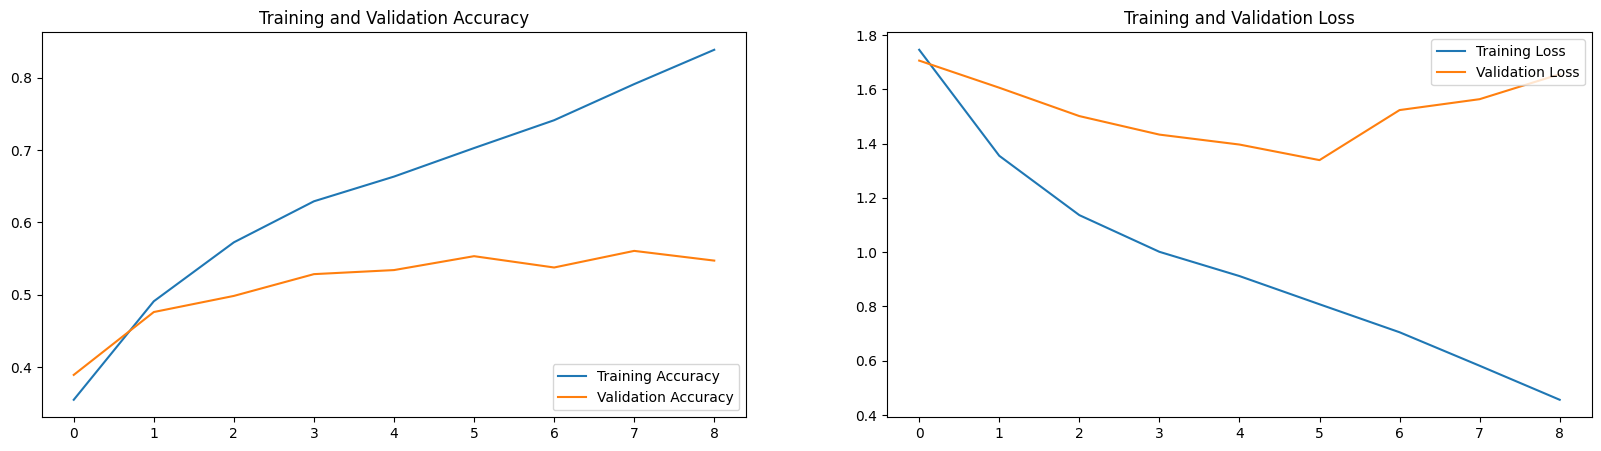

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

115/115 [==============================] - 8s 68ms/step - loss: 1.0953 - accuracy: 0.6112
final train accuracy = 78.76 , validation accuracy = 61.12


## Plotting Confusion Matrix

115/115 [==============================] - 8s 67ms/step


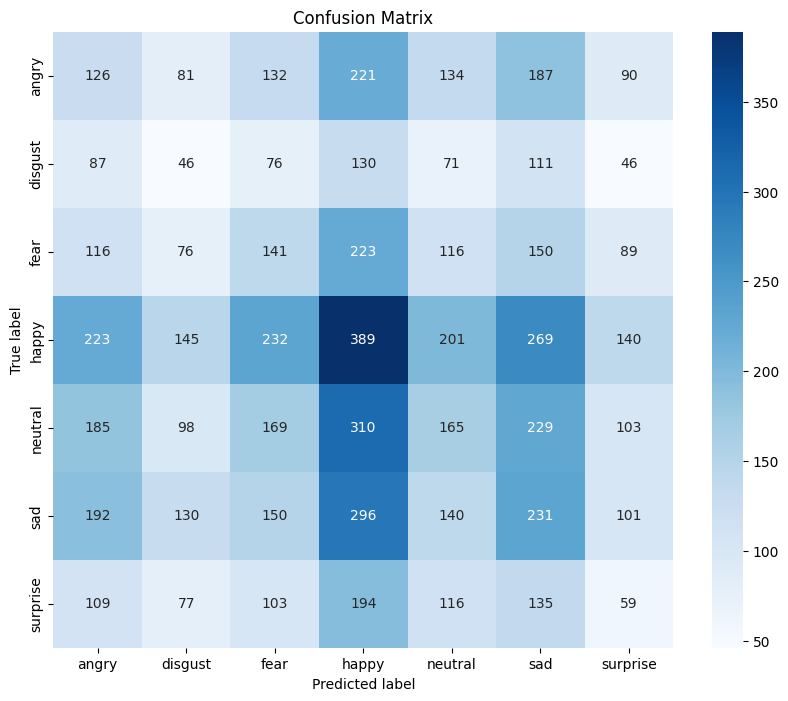

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Printing Classification Report

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.13      0.13       971
     disgust       0.07      0.08      0.08       567
        fear       0.14      0.15      0.15       911
       happy       0.22      0.24      0.23      1599
     neutral       0.17      0.13      0.15      1259
         sad       0.18      0.19      0.18      1240
    surprise       0.09      0.07      0.08       793

    accuracy                           0.16      7340
   macro avg       0.14      0.14      0.14      7340
weighted avg       0.16      0.16      0.16      7340



## Making Predictions

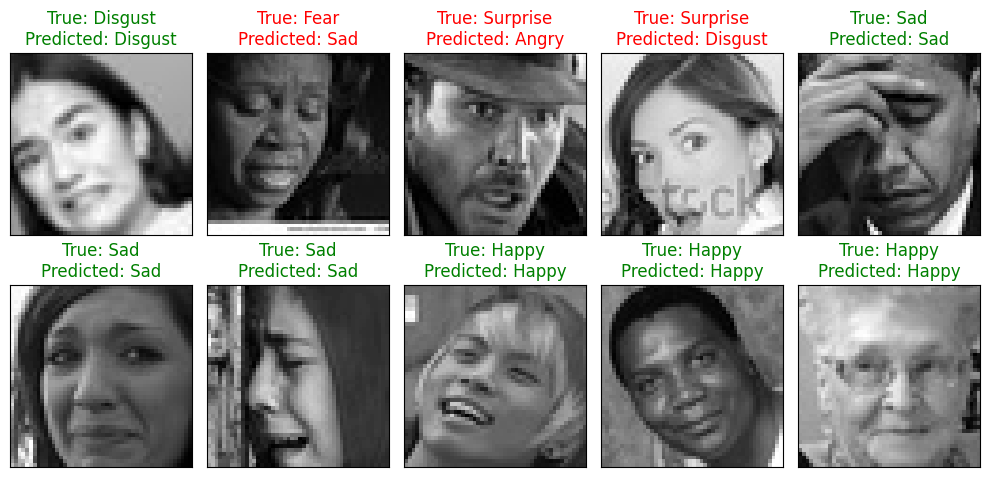

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: VGG16 using Transfer Learning

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train_dir'
test_data_dir = '/content/test_dir'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 29417 images belonging to 7 classes.
Found 7340 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.083100147275405, 1: 1.8082739119744282, 2: 1.1500899210258817, 3: 0.6571428571428571, 4: 0.8344774764552366, 5: 0.8474346786506496, 6: 1.326105576342244}


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/FER/Facial_Emotion_Recognizer/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/FER/VGG16_Transfer_Learning.keras')

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=25,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
)

Epoch 1/25
460/460 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.6345
Epoch 1: val_loss improved from inf to 0.98956, saving model to /content/drive/MyDrive/FER/Facial_Emotion_Recognizer/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
460/460 [==============================] - 474s 1s/step - loss: 0.9465 - accuracy: 0.6345 - val_loss: 0.9896 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 2/25
460/460 [==============================] - ETA: 0s - loss: 0.9334 - accuracy: 0.6433
Epoch 2: val_loss did not improve from 0.98956
460/460 [==============================] - 459s 998ms/step - loss: 0.9334 - accuracy: 0.6433 - val_loss: 0.9906 - val_accuracy: 0.6223 - lr: 1.0000e-04
Epoch 3/25
460/460 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.6496
Epoch 3: val_loss did not improve from 0.98956
460/460 [==============================] - 439s 952ms/step - loss: 0.9108 - accuracy: 0.6496 - val_loss: 1.0027 - val_accuracy: 0.6275 - lr: 1.000

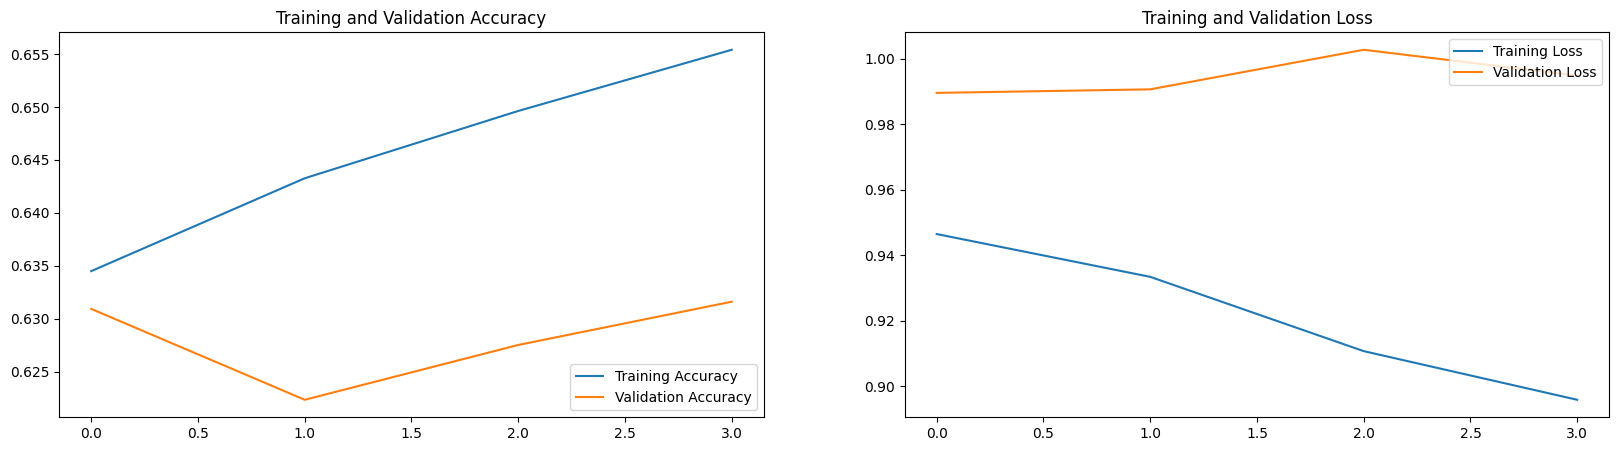

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

115/115 [==============================] - 28s 246ms/step - loss: 0.9896 - accuracy: 0.6309
final train accuracy = 66.19 , validation accuracy = 63.09


115/115 [==============================] - 28s 247ms/step


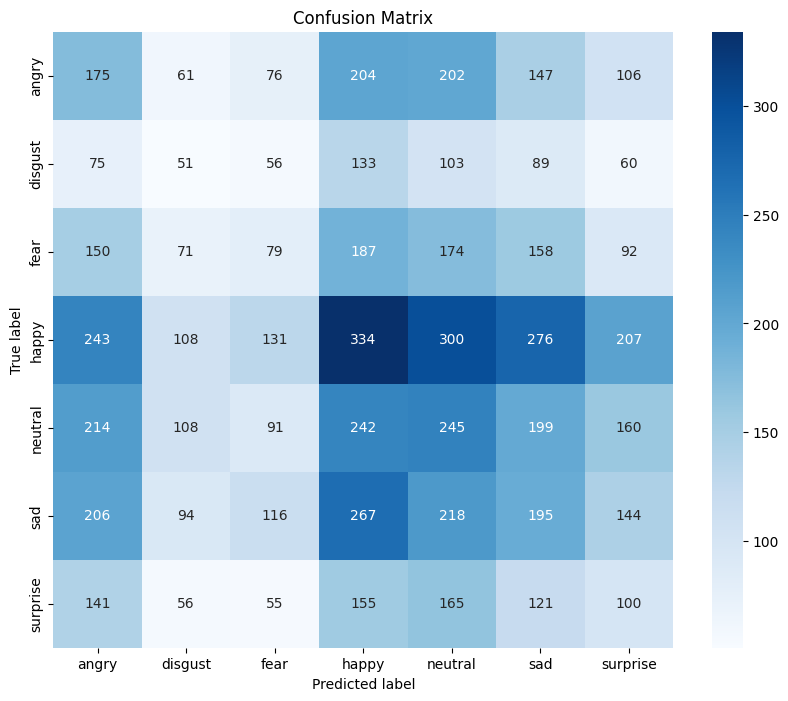

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.18      0.16       971
     disgust       0.09      0.09      0.09       567
        fear       0.13      0.09      0.10       911
       happy       0.22      0.21      0.21      1599
     neutral       0.17      0.19      0.18      1259
         sad       0.16      0.16      0.16      1240
    surprise       0.12      0.13      0.12       793

    accuracy                           0.16      7340
   macro avg       0.15      0.15      0.15      7340
weighted avg       0.16      0.16      0.16      7340



# Model 3: ResNet50 using Transfer Learning

In [5]:
# Directory paths for training and testing data
train_dir = '/content/train_dir'
test_dir = '/content/test_dir'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 29417 images belonging to 7 classes.
Found 7340 images belonging to 7 classes.


## Introducing Class Weights for imbalanced data

In [6]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.083100147275405, 1: 1.8082739119744282, 2: 1.1500899210258817, 3: 0.6571428571428571, 4: 0.8344774764552366, 5: 0.8474346786506496, 6: 1.326105576342244}


In [7]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():
    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

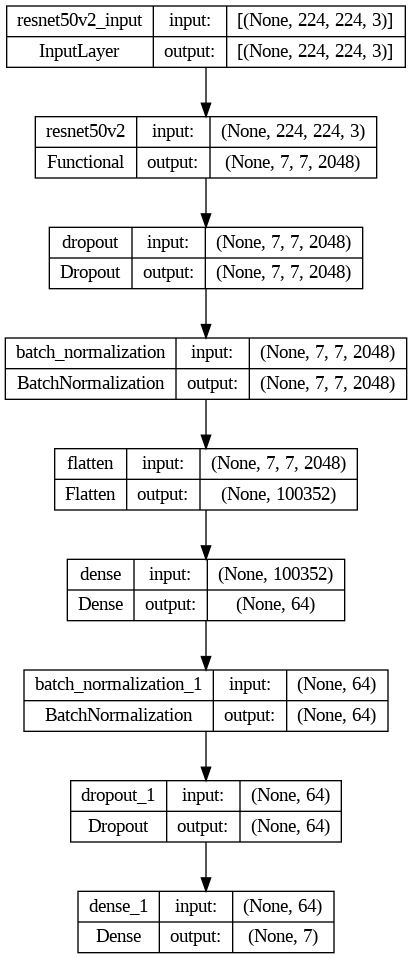

In [12]:
plot_model(model, to_file = '/content/drive/MyDrive/Facial_Emotion_Recognizer/ResNet50_Transfer_Learning/Architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Facial_Emotion_Recognizer/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger('training.log')

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [9]:
model = load_model('/content/drive/MyDrive/Facial_Emotion_Recognizer/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning')

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=10,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/10
460/460 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7355
Epoch 1: val_loss did not improve from 0.85698
460/460 [==============================] - 422s 916ms/step - loss: 0.6999 - accuracy: 0.7355 - val_loss: 0.9006 - val_accuracy: 0.6931
Epoch 2/10
460/460 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7449
Epoch 2: val_loss did not improve from 0.85698
460/460 [==============================] - 423s 921ms/step - loss: 0.6926 - accuracy: 0.7449 - val_loss: 0.8741 - val_accuracy: 0.6891
Epoch 3/10
460/460 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.7479
Epoch 3: val_loss did not improve from 0.85698
460/460 [==============================] - 422s 918ms/step - loss: 0.6793 - accuracy: 0.7479 - val_loss: 0.9083 - val_accuracy: 0.6757
Epoch 4/10
460/460 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7512
Epoch 4: val_loss did not improve from 0.85698
460/460 [==============

In [17]:
model.save("/content/drive/MyDrive/Facial_Emotion_Recognizer/ResNet50_Transfer_Learning/Best_Model.keras")

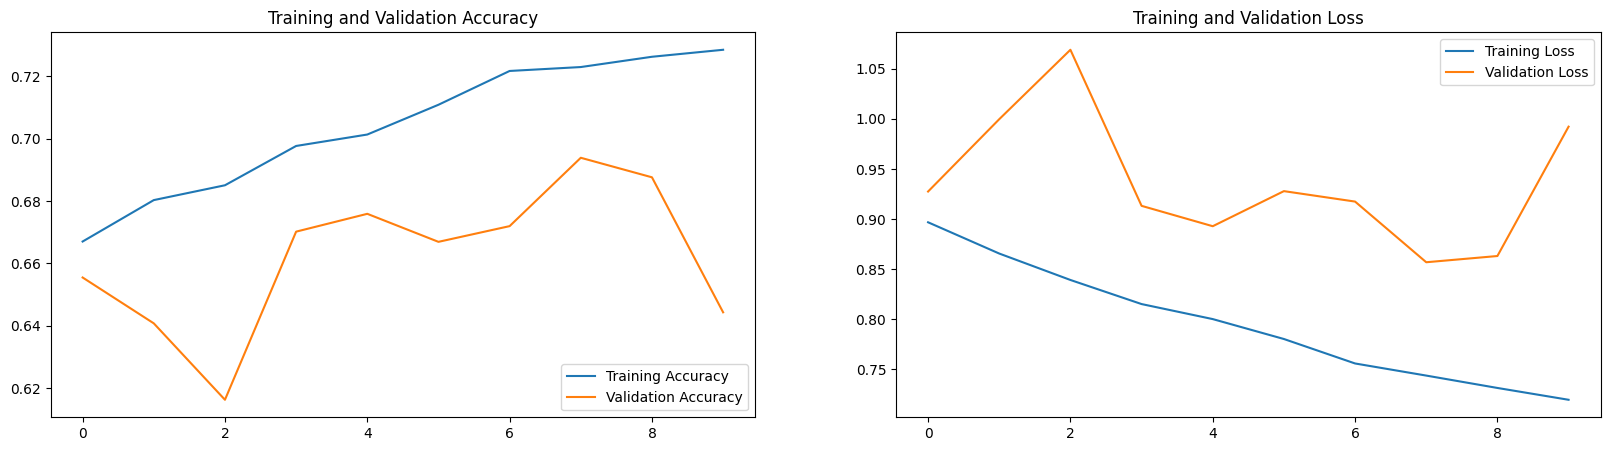

In [14]:
plot_training_history(train_history)

In [18]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

115/115 [==============================] - 20s 175ms/step - loss: 0.9922 - accuracy: 0.6443
final train accuracy = 71.51 , validation accuracy = 64.43


115/115 [==============================] - 28s 234ms/step


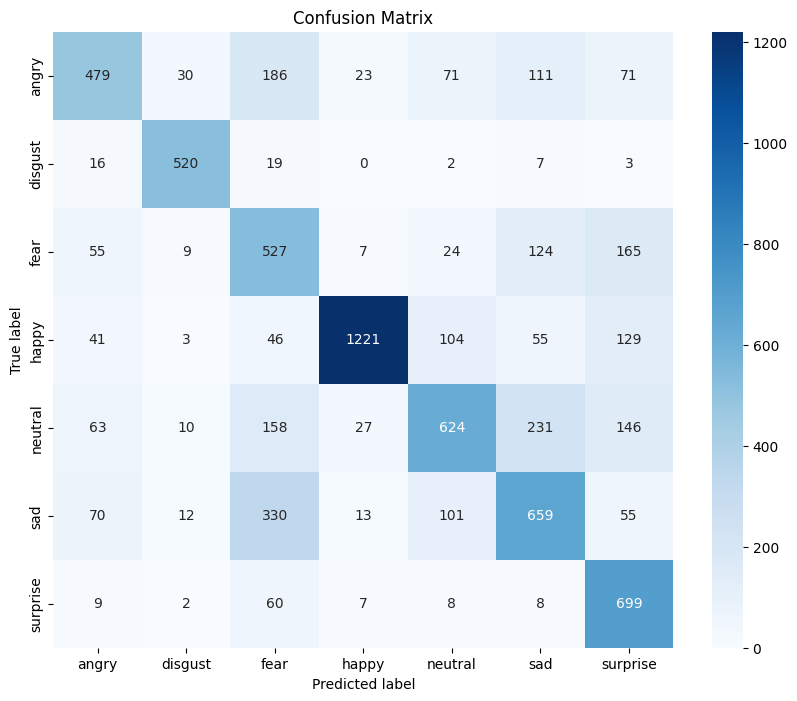

In [20]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.65      0.49      0.56       971
     disgust       0.89      0.92      0.90       567
        fear       0.40      0.58      0.47       911
       happy       0.94      0.76      0.84      1599
     neutral       0.67      0.50      0.57      1259
         sad       0.55      0.53      0.54      1240
    surprise       0.55      0.88      0.68       793

    accuracy                           0.64      7340
   macro avg       0.66      0.67      0.65      7340
weighted avg       0.68      0.64      0.65      7340



## AUC ROC plot

In [22]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

115/115 [==============================] - 27s 238ms/step


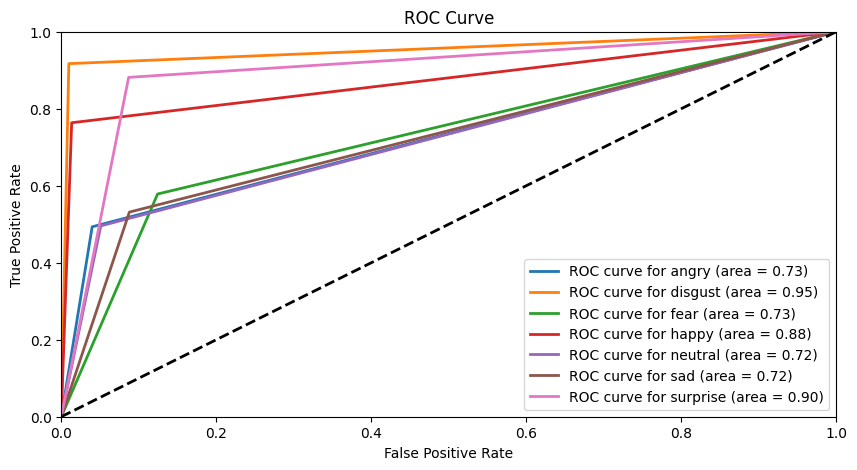

In [23]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

## Model Save to Hugging Face Models

In [19]:
!pip install huggingface_hub

In [24]:
from huggingface_hub import login

login(token="<<Hf token>>")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [28]:
from huggingface_hub import HfApi, HfFolder, Repository

# Define your repository name
repo_name = "dilkushsingh/Facial_Emotion_Recognizer"

# Clone the repository
repo = Repository(local_dir=repo_name, clone_from=repo_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/dilkushsingh/Facial_Emotion_Recognizer is already a clone of https://huggingface.co/dilkushsingh/Facial_Emotion_Recognizer. Make sure you pull the latest changes with `repo.git_pull()`.


In [36]:
# Copy your model files to the repository
# Define the repository name as a string
repo_name = "Facial_Emotion_Recognizer"

# Use the correct cp command
!cp -r '/content/drive/MyDrive/Facial_Emotion_Recognizer' {repo_name}/


cp: cannot overwrite directory 'Facial_Emotion_Recognizer/Facial_Emotion_Recognizer' with non-directory


In [35]:
# Push the model to Hugging Face
repo.push_to_hub(commit_message="Initial commit")